In [1]:
!pip install blosc2
!pip install hdbscan
!pip install bertopic

In [2]:
import pandas as pd
import numpy as np
import json
import requests
import es_core_news_lg

import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from kmodes.kprototypes import KPrototypes
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from umap import UMAP
from transformers.pipelines import pipeline

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance

plt.style.use('ggplot')

c:\Users\johan\anaconda3\envs\bertopic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path="pqr_processed.csv"
df=pd.read_csv(path, sep=';', index_col=0)
df.head()

,MOTIVO,PQR,USUARIO
0,Afiliaciones,mil veintitres senores en lozano identificad...,41859039
1,Faltante de medicamentos y aliadas,requiere medicamentos alginato sodio bicarbo...,52294841
2,Faltante de medicamentos y aliadas,gonzalez gonzalez de tardes cordial...,65090345
3,Citas Medicas,la inquietud queja prestada nombrado odontolo...,1053988549
4,Calidad Tecnico Cientifica,queja me dirijo presentar queja formal ciruja...,1047595573


In [4]:
df['PQR'] = df['PQR'].astype(str)
pqr = df['PQR'].tolist()

In [5]:
#stopwords
nlp = es_core_news_lg.load()
spanish_stop_words_spacy = nlp.Defaults.stop_words
vectorizer = CountVectorizer(lowercase = True, stop_words = list(spanish_stop_words_spacy))


In [6]:
umap_model = UMAP(angular_rp_forest=True,
            low_memory=False,
            metric='cosine',
            min_dist=0.0,
            n_components=5,
            random_state=42,
            tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [7]:

vectorizer_model = vectorizer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
#representation_model = KeyBERTInspired()
#representation_model = MaximalMarginalRelevance(diversity=0.8)


topic_model = BERTopic(
    umap_model=umap_model,
    ctfidf_model=ctfidf_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True)

topics, probs = topic_model.fit_transform(pqr)

#topic_model = BERTopic(embedding_model="PlanTL-GOB-ES/roberta-base-bne", calculate_probabilities=True, verbose=True)
#topics, probs = topic_model.fit_transform(pqr)

Batches: 100%|██████████| 177/177 [03:06<00:00,  1.05s/it]
2023-11-12 21:27:48,281 - BERTopic - Transformed documents to Embeddings
2023-11-12 21:28:17,706 - BERTopic - Reduced dimensionality
2023-11-12 21:28:19,191 - BERTopic - Clustered reduced embeddings


In [8]:
topic_model.visualize_topics()

In [9]:
# we observe the first 25 topics
top_topics = 25

topics_pivot = topic_model.get_topic_info()

events_count = topics_pivot['Count'].sum()

def calc_perc(row):
  return round(row['Count']*100/events_count, 2)

topics_pivot['Perc'] = topics_pivot.apply (lambda row: calc_perc(row), axis=1)

topics_pivot.head(top_topics)

,Topic,Count,Name,Representation,Representative_Docs,Perc
0,-1,2124,-1_incapacidades_incapacidad_la_solicitando,"[incapacidades, incapacidad, la, solicitando, ...",[ erika milena gomez a erika milena gomez a ...,37.71
1,0,726,0_urgencias_dolor_ciudad_nina,"[urgencias, dolor, ciudad, nina, situacion, ma...",[a correspondaeps presente dirijo representan...,12.89
2,1,235,1_medicamento_tabletas_medicamentos_cantidad,"[medicamento, tabletas, medicamentos, cantidad...",[ nancy camargo camargo de requiere con o...,4.17
3,2,191,2_validacion_comunicarse_normatividad_gestion,"[validacion, comunicarse, normatividad, gestio...",[ juan gabriel londono grajales no no peticio...,3.39
4,3,136,3_ojo_vision_oftalmologia_glaucoma,"[ojo, vision, oftalmologia, glaucoma, retina, ...",[ se senora radicando consagra disposicio...,2.41
5,4,108,4_cerebro_neurologia_magnetica_resonancia,"[cerebro, neurologia, magnetica, resonancia, c...",[senores superintendencia soy nino reporto q...,1.92
6,5,105,5_transporte_ciudad_hospedaje_conductor,"[transporte, ciudad, hospedaje, conductor, dia...",[ yackson gomez n gomez de pino afiliado...,1.86
7,6,105,6_corazon_cardiologo_cardiologia_cardiaca,"[corazon, cardiologo, cardiologia, cardiaca, p...",[mediante presente pongo conocimiento queja p...,1.86
8,7,79,7_ortopedia_osteotomia_tibia_traumatologia,"[ortopedia, osteotomia, tibia, traumatologia, ...",[ sanchez de sandoval del dolores sanchez de s...,1.40
9,8,73,8_tumor_cancer_maligno_quimioterapias,"[tumor, cancer, maligno, quimioterapias, metas...",[actualmente diagnosticada patologia hodgkin l...,1.30


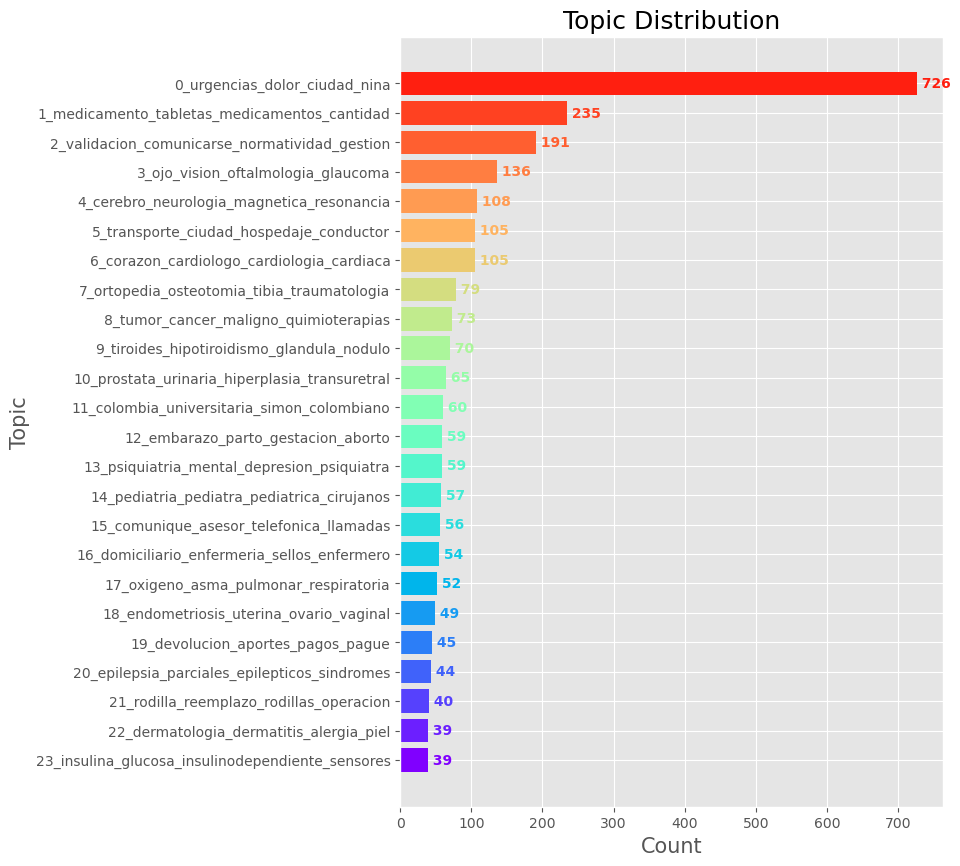

In [10]:
colors = plt.cm.rainbow(np.linspace(0, 1, top_topics))
iter_color = iter(colors)

fig = plt.figure(figsize=(7,10))

plt.barh('Name', 'Count',
         data=topics_pivot.head(top_topics).drop([0]).sort_values('Count',ascending=True), color=colors)
plt.xlabel("Count", size=15)
plt.ylabel("Topic", size=15)
plt.title("Topic Distribution", size=18)

for i, v in enumerate(topics_pivot.head(top_topics).drop([0])["Count"].sort_values(ascending=True)):
  c = next(iter_color)
  plt.text(v, i, " "+str(v), color=c, va='center', fontweight='bold')

In [11]:
#df processecd
export_df=topic_model.get_document_info(pqr,df=df)
file_name = "pqr_topic_result.csv"
export_df.to_csv(file_name, sep=';',encoding='utf-8')
export_df

,MOTIVO,PQR,USUARIO,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Afiliaciones,mil veintitres senores en lozano identificad...,41859039,mil veintitres senores en lozano identificad...,0,0_urgencias_dolor_ciudad_nina,"[urgencias, dolor, ciudad, nina, situacion, ma...",[a correspondaeps presente dirijo representan...,urgencias - dolor - ciudad - nina - situacion ...,0.080921,False
1,Faltante de medicamentos y aliadas,requiere medicamentos alginato sodio bicarbo...,52294841,requiere medicamentos alginato sodio bicarbo...,1,1_medicamento_tabletas_medicamentos_cantidad,"[medicamento, tabletas, medicamentos, cantidad...",[ nancy camargo camargo de requiere con o...,medicamento - tabletas - medicamentos - cantid...,0.237039,False
2,Faltante de medicamentos y aliadas,gonzalez gonzalez de tardes cordial...,65090345,gonzalez gonzalez de tardes cordial...,-1,-1_incapacidades_incapacidad_la_solicitando,"[incapacidades, incapacidad, la, solicitando, ...",[ erika milena gomez a erika milena gomez a ...,incapacidades - incapacidad - la - solicitando...,0.851400,False
3,Citas Medicas,la inquietud queja prestada nombrado odontolo...,1053988549,la inquietud queja prestada nombrado odontolo...,47,47_dientes_dentales_carilla_exodoncia,"[dientes, dentales, carilla, exodoncia, piezas...",[berenice riveros de chacon chacon riveros a ...,dientes - dentales - carilla - exodoncia - pie...,1.000000,False
4,Calidad Tecnico Cientifica,queja me dirijo presentar queja formal ciruja...,1047595573,queja me dirijo presentar queja formal ciruja...,-1,-1_incapacidades_incapacidad_la_solicitando,"[incapacidades, incapacidad, la, solicitando, ...",[ erika milena gomez a erika milena gomez a ...,incapacidades - incapacidad - la - solicitando...,0.252545,False
...,...,...,...,...,...,...,...,...,...,...,...
5628,Medicina Laboral,buen solicito amable colaboracion realizando v...,901287668,buen solicito amable colaboracion realizando v...,-1,-1_incapacidades_incapacidad_la_solicitando,"[incapacidades, incapacidad, la, solicitando, ...",[ erika milena gomez a erika milena gomez a ...,incapacidades - incapacidad - la - solicitando...,0.088256,False
5629,Cobertura,presencia organizacion gubernamental trabaja p...,891184665,presencia organizacion gubernamental trabaja p...,0,0_urgencias_dolor_ciudad_nina,"[urgencias, dolor, ciudad, nina, situacion, ma...",[a correspondaeps presente dirijo representan...,urgencias - dolor - ciudad - nina - situacion ...,0.055798,False
5630,Procesos Administrativos,de forma respetuosa permito queja cajera atend...,32994845,de forma respetuosa permito queja cajera atend...,-1,-1_incapacidades_incapacidad_la_solicitando,"[incapacidades, incapacidad, la, solicitando, ...",[ erika milena gomez a erika milena gomez a ...,incapacidades - incapacidad - la - solicitando...,0.613214,False
5631,Prestaciones Economicas,yo calidad representante legal solicito pres...,1020600791,yo calidad representante legal solicito pres...,19,19_devolucion_aportes_pagos_pague,"[devolucion, aportes, pagos, pague, planilla, ...",[ a a de trabajador contrato servicios v...,devolucion - aportes - pagos - pague - planill...,0.104516,False
